<a href="https://colab.research.google.com/github/hengkuanwee/CNN-model-to-classify-eczema-Transfer-Learning_Inceptionv3/blob/master/Kuan_Wee's_Project_Submission_(TL_CNN_for_types_of_dermatitis_(skin_condition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hi Martin and Sam,**

I had the following code which worked well when i had a different training/validation set. However, to make my model more robust, i went to download a whole new larger training/validation set to train the model which gave me errors at
- step 2) d. Visualise the dataset and
- step 3) Train the model

Been struggling to resolve the issue but to no avail, please help!!!

# CNN for Dermatitis

I have dermatitis (i.e. eczema) since childhood and is hence really interested in building a model in which users will be able to classify the different types of dermatitis currently known to us. 

From the National Skin centre webpage
([link text](https://https://www.nsc.com.sg/Patient-Guide/Health-Library/Types%20of%20Skin%20Conditions/Pages/Eczema-and-Dermatitis.aspx) )
I notice that there are 5 different categories of eczema:

1.   Seborrhoeic Dermatitis
2.   Discoid Eczema
3.   Asteatotic
4.   Venous Eczema
5.   Contact Dermatitis (I decided not to classify this as the symptoms depends largely on the cause, the irritant or allergen that came in contact with the skin)

Therefore, I will try to create a dermatitis classifer model using transfer learning with Inception v3, hopefully it works!!!

**p.s. Please kindly provide me with comments on how to improve the model, really appreciate your teaching and the effort :)**

The following are questions which I have after finishing the project and unable to find useful sources online
1.   Currently I tried image augmentation on the data image (the number of training/validation data remains unchange). I am unsure of how to increase the number of training/validation data after carrying out image augmentation

2.   My data visualisation of training/validation dataset encounters errors depending on the tensorflow version (at least that is what I think, and I am not sure why)

3.   How to create a multi-label model, as I am interested in creating a model that can classify a wider range of skin diseases. e.g. Eczema -> sub-set of Eczema vs Ringworm -> Subset of Ringworm

# Step 1) Importing the Libraries

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, json
import numpy as np
import pandas as pd
from glob import glob
from google.colab import files

'''#I wanted to visualize the augmented images in Step 2) d. Visualize the dataset, however I realised that I can only do it after importing the following but I am unsure why. Please kindly advise.
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass'''
!pip install -qq tf-nightly-gpu-2.0-preview
import tensorflow as tf

from tensorflow.keras.applications import inception_v3
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K



In [0]:
print(tf.__version__)

2.0.0-dev20191002


# Step 2) Preparing the Dataset

> **a. Import the Dataset** (The dataset are obtained     from google images as it was difficult to obtain a ready made data source)

> **b. Dataset Preprocessing to tf data** (To preprocess the data into formats that can feed into tf models)

> **c. Dataset Pipeline with Augmentation** (Pipeline for loading and resizing of images)

> **d. Visualize the dataset** (To verify that image Augmentation is done properly)

**a. Import the Dataset**

In [0]:
#Import the file from Local Drive as my Dropbox and Google Drive is hitting its storage limit
uploaded = files.upload()

MessageError: ignored

In [0]:
#Unzip the dataset
!unzip -qq Dataset_Dermatitis.zip #Unzip the dataset
!rm Dataset_Dermatitis.zip #Removing the zip file
!rm -r __MACOSX #I do not use Mac, but apparently Mac creates a __MACOSX folder when folders are unzipped (please correct me if I am wrong) leaving this code here for Mac user

!ls

unzip:  cannot find or open Dataset_Dermatitis.zip, Dataset_Dermatitis.zip.zip or Dataset_Dermatitis.zip.ZIP.
rm: cannot remove 'Dataset_Dermatitis.zip': No such file or directory
rm: cannot remove '__MACOSX': No such file or directory
Dataset_Dermatitis  sample_data


**b. Dataset Preprocessing to tf data**

In [0]:
path = "./Dataset_Dermatitis/train/"
validation_data_dir = "./Dataset_Dermatitis/valid/"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root,name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))
    
df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes


                                            filename  ... class
0  /content/Dataset_Dermatitis/train/Discoid Ecze...  ...     1
1  /content/Dataset_Dermatitis/train/Venous Eczem...  ...     3
2  /content/Dataset_Dermatitis/train/Seborrhoeic ...  ...     2
3  /content/Dataset_Dermatitis/train/Venous Eczem...  ...     3
4  /content/Dataset_Dermatitis/train/Venous Eczem...  ...     3

[5 rows x 3 columns]
161


filename        object
class_name    category
class             int8
dtype: object

In [0]:
# Split into train and validation sets
train_set_percentage = .9


df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

**c. Dataset Pipeline with Augmentation**

In [0]:
tf.executing_eagerly()

True

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299
num_classes = 4
batch_size = 32

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  
  #Image augmentation
  # resizing
  if np.random.uniform() > 0.5:
    image_decoded = tf.image.resize_with_crop_or_pad(image_decoded, img_rows, img_cols)
  else:
    image_decoded = tf.image.random_crop(image_decoded, size=[img_rows, img_cols, 3])

  # Image augmentation 
  image_decoded = tf.image.random_flip_left_right(image_decoded,seed=23)
  image_decoded = tf.image.random_flip_up_down(image_decoded, seed=None )

  # Contrast and Brightness
  if np.random.uniform() > 0.4:
    image_decoded = tf.image.random_contrast(image_decoded, 0.1,0.9,seed=None)
  if np.random.uniform() > 0.4:
    image_decoded = tf.image.random_brightness(image_decoded, max_delta= 0.05, seed=None)
    image_decoded = tf.image.random_hue(image_decoded, max_delta= 0.05, seed=None)
  
  image_resized = image_decoded
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
image_string = tf.io.read_file('./content/Dataset_Dermatitis/train/Discoid Eczema/Discoid_001.jpg/')

NotFoundError: ignored

In [0]:
#Assembling the Data pipeline using tf.data of train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(260)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
#Assembling the Data pipeline using tf.data of validation dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(260)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
#Checking for format of train and validation datasets
print(train_dataset)
print(valid_dataset)

<BatchDataset shapes: ((32, 299, 299, 3), (32, 4)), types: (tf.uint8, tf.float32)>
<BatchDataset shapes: ((32, 299, 299, 3), (32, 4)), types: (tf.uint8, tf.float32)>


**d. Visualize the dataset**

In [0]:
#Visualise the train_dataset
for batch in train_dataset:
    image_batch, label_batch = batch[0], batch[1]
    
    plt.figure(figsize=(13,13))
    subplot=331
    for i,image in enumerate(image_batch):
      plt.subplot(subplot)
      plt.axis('off')
      plt.imshow(image.numpy().astype(np.uint8))
      #plt.title(label_batch[i] , fontsize=16)
      subplot += 1
      if i==6:
        break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    break

InvalidArgumentError: ignored

# Step 3) Import Inception v3 network weights

In [0]:
# create the base pre-trained model
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3),pooling=None)

In [0]:
# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
# x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
# x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 4 classes
predictions = Dense(4, activation='softmax')(x)

In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    if 'batch_normalization' in layer.name:
      #print(layer.name)
      layer.trainable = True
    else:
      #print(layer.name)
      layer.trainable = False

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [0]:
train_steps = int(260/32) #total trains set / batch_size
val_steps = int(260/32)
epochs = 10

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 8
val steps: 8


In [0]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Train for 8 steps, validate for 8 steps
Epoch 1/10
1/8 [==>...........................] - ETA: 57s

InvalidArgumentError: ignored

In [0]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

# Step 4) Prediction with the trained model
I took a few more images from google images to test out the trained model, lets see how it goes! :)\

> a. Import the Dataset (The dataset are obtained from google images as it was difficult to obtain a ready made data source)

> b. Preprocess the image

> c. Making predictions

**a. Import the dataset**

In [0]:
#Dataset already imported above, not needed
#uploaded = files.upload()

**b. Preprocess the image**

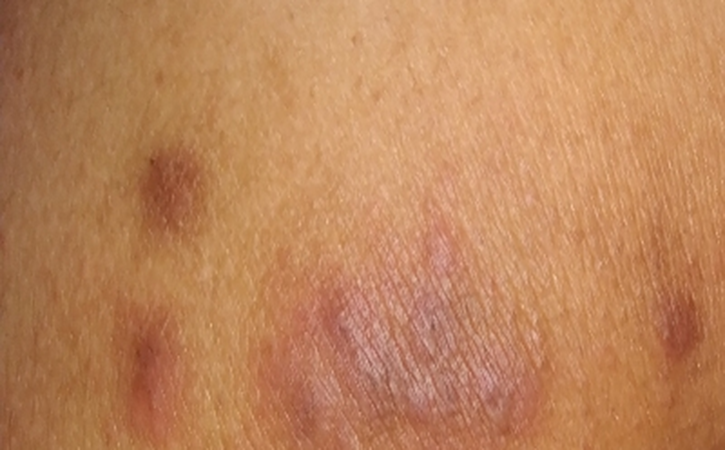

In [0]:
image_path = "./Dataset_Dermatitis/test/"

from IPython.display import Image

image_check = 'Discoid_Eczema_046.png'

Image(image_path+image_check)

In [0]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./Dataset_Dermatitis/test/Discoid_Eczema_046.png
Input image shape: (1, 299, 299, 3)


**c. Making predictions**

In [0]:
preds = model.predict(x)

array([[0.10544567, 0.5838696 , 0.24394834, 0.06673636]], dtype=float32)

In [0]:
print('Predicted:', preds)

Predicted: [[0.10544567 0.5838696  0.24394834 0.06673636]]


In [0]:
result = np.argmax(preds[0])
if result == 0:
    print("It's Asteatotic")
if result == 1:
    print("It's Discoid Eczema")
if result == 2:
    print("It's Seborrhoeic Dermatitis")
if result == 3:
    print("It's Venous Eczema")

It's Discoid Eczema
